# Turb2D 2021 Data

### On OSPC
Data are stored in `'/home/dicarlo_d/Documents/Datasets/Turb2D.hdf5'`

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

In [3]:
data_path = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
data_path.exists()

True

In [4]:
from turboflow.datasets.turb2D import Turb2D

In [5]:
data_home = Path('/','home','dicarlo_d','Documents','Datasets')
turb2D = Turb2D(data_path)

In [8]:
turb2D.cite()

========== BibTeX ==========

@misc{heitz2007deliverable,
  title={Final report on the evaluation of the tasks of the workpackage 2, FLUID project deliverable 5.4.},
  author={Heitz, Dominique and Carlier, Johan and Arroyo, Georges and Szantai, Andr{'e}}
  year={2007},
}



In [9]:
turb2D.validate()

Check data dimensions... done!


## Single Image data

In [43]:
t = 666
turb2D.load_data(t, only_vel_field=False)

In [34]:
X = turb2D.xy
u = turb2D.uv

print(X.shape)
print(u.shape)

(256, 256, 2)
(256, 256, 2)


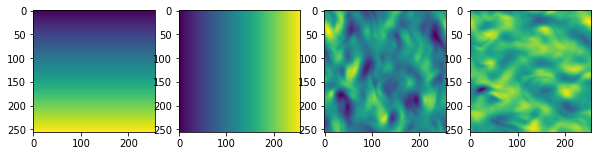

In [35]:
plt.figure(figsize=(10,10))
plt.subplot(141)
plt.imshow(X[:,:,0])
plt.subplot(142)
plt.imshow(X[:,:,1])
plt.subplot(143)
plt.imshow(u[:,:,0])
plt.subplot(144)
plt.imshow(u[:,:,1])
plt.show()

In [36]:
import turboflow.utils.viz_utils as viz
import turboflow.utils.phy_utils as phy

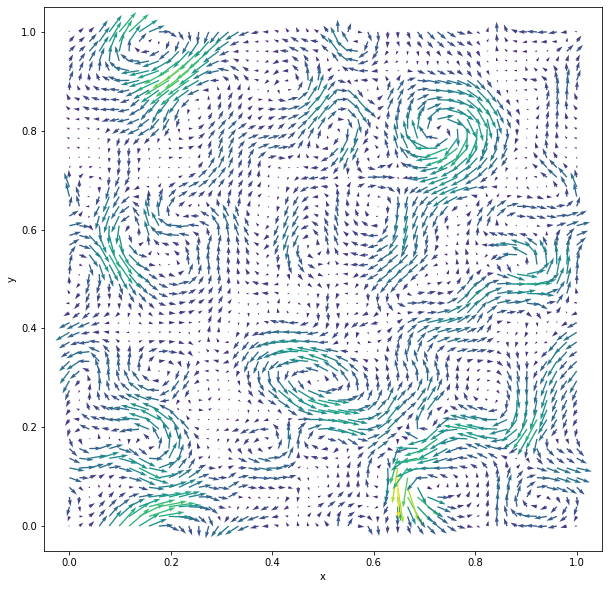

In [37]:
fig=plt.figure(figsize=(10,10))
ax = fig.gca()
viz.plot_field((X[:,:,0], X[:,:,1]), 
               (u[:,:,0], u[:,:,1]), step=5, scale=50, ax=ax, indexing='ij')
plt.show()

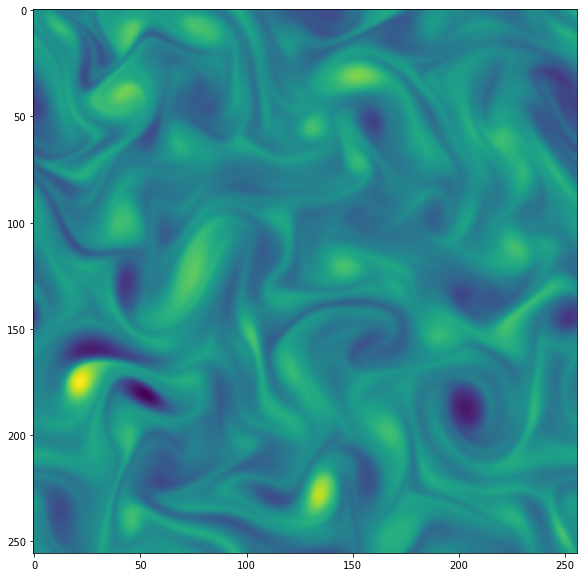

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
w = phy.compute_vorticity((X[:,:,0],X[:,:,1]),
                          (u[:,:,0],u[:,:,1]), indexing='ij')
plt.imshow(w)
plt.show()

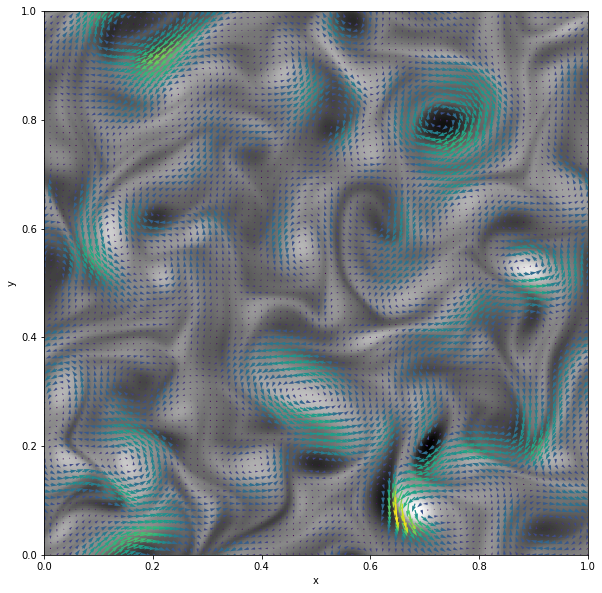

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
viz.plot_field((X[:,:,0],X[:,:,1]),
               (u[:,:,0],u[:,:,1]), vorticity_img=w, step=3, scale=100, ax=ax)
plt.show()

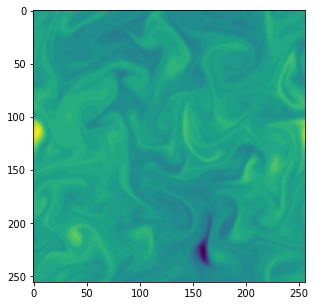

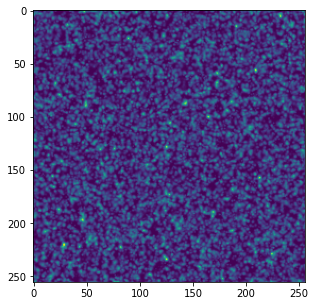

In [44]:
plt.figure(figsize=(5,5))
plt.imshow(turb2D.scalar)

plt.figure(figsize=(5,5))
plt.imshow(turb2D.particle)

## Multiple images

In [51]:
from tqdm import tqdm
from IPython.display import HTML
from matplotlib import animation

In [45]:
t = np.arange(1000)
turb2D.load_data(t, only_vel_field=False)

In [53]:
fig, axarr = plt.subplots(1,1, figsize=(10,10))

ims = []
for i in tqdm(range(1000)):
    
    data = turb2D.uv[i,:,:,0]
    im1 = axarr.imshow(data, animated=True)
    
    ims.append([im1])
    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
plt.close()

# Show the animation
HTML(ani.to_html5_video())

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 902.12it/s]


In [231]:
# fig, axarr = plt.subplots(1,1, figsize=(10,10))

# ims = []
# for i in tqdm(range(100)):
    
#     turb2D.load_data(i)
#     sc = turb2D.scalar
#     sc = np.concatenate([sc, sc], axis=0)
#     sc = np.concatenate([sc, sc], axis=1)
#     im1 = axarr.imshow(sc, animated=True)
    
#     ims.append([im1])
    
# ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

# plt.close()

# # Show the animation
# HTML(ani.to_html5_video())

  0%|          | 0/50 [00:00<?, ?it/s]

In [182]:
from turboflow.dataloaders import Turb2DDataset

In [183]:
data_dir = pathlib.Path('..','.cache','Turb2D.hdf5')
td = Turb2DDataset(data_dir, time_idx=33, ds=1)

print(td.res)
print(td.img_shape)

256
(256, 256)


In [184]:
X, y = td[:]
print(X.shape)
print(y.shape)

torch.Size([65536, 2])
torch.Size([65536, 2])


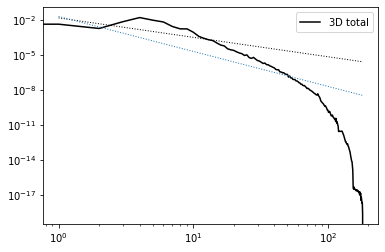

In [209]:
R = td.res

uv = y.view(R, R, 2)     # (R*R, 2)
uv = uv.permute(2, 0, 1) # (R, R, 2) -> (2, R, R)

E, k = phy.energy_spectrum(uv)

# wavenumber
wavenumber = (2*np.pi)*(k*(1/256))

plt.loglog(k_bin, Ekt, color='black', lw=1.5, label=r'$3\mathrm{D}\,\, \mathrm{total}$')
c = 0.015
plt.loglog([min(k[1:]), max(k)], 
           [c*min(k[1:])**(-5./3.), c*max(k)**(-5./3.)],
           color='black', lw=1, ls='dotted')
c = 0.02
plt.loglog([min(k[1:]), max(k)],
           [c*min(k[1:])**(-3.), c*max(k)**(-3.)],
           color='C0', lw=1, ls='dotted')

plt.legend()
plt.show()

In [210]:
Re = 3000
nu = 1/Re

print('TKE', phy.tkenergy(uv).item())
print('Dissipation', phy.dissipation(uv, viscosity=nu).item())
print('RMSE', phy.rmsvelocity(uv).item())
print('Taylor Micro scale', phy.tmscale(uv, viscosity=nu).item())
print('Taylor-scale Reynolds', phy.tsreynolds(uv, viscosity=nu).item())
print('Kolmogorov Time', phy.ktimescale(uv, viscosity=nu))
print('Kolmogorov Lenght', phy.klenscale(uv, viscosity=nu))
print('Integral scale', phy.intscale(uv))

TKE 0.027043433859944344
Dissipation 3.144378646346979e-10
RMSE 0.02208087220788002
Taylor Micro scale 88.0509033203125
Taylor-scale Reynolds 5832.72216796875
Kolmogorov Time tensor(1029.6082)
Kolmogorov Lenght tensor(0.5858)
Integral scale tensor(inf, dtype=torch.float64)


/home/dicarlo_d/Documents/Code/TurboSuperResultion/turboflow/utils/phy_utils.py:332: RuntimeWarning: divide by zero encountered in true_divide


## PROCESS FILES
### Extract TEXT (X,Y,U,V)

In [ ]:
# img_dir = '../../../Datasets/2021-Turb2D/shifttruth1000-txt.txt/'
# imgs = sorted(glob.glob(img_dir + '*.txt'))

# nimgs = len(imgs)

# Turb2D = np.zeros((nimgs,256,256,4))

# for i, img_path in enumerate(tqdm(imgs)):
#     img = np.loadtxt(open(img_path, "rb"))
#     for v in range(4):
#         Turb2D[i,:,:,v] = img[:,v].reshape(256,256)

# outfile = '../data/2021-Turb2D_velocities.npy'
# np.save(outfile, Turb2D)

### Extract Particles

In [ ]:
# img_dir = '../../../Datasets/2021-Turb2D/particle/'
# imgs = sorted(glob.glob(img_dir + '*.tif'))

# nimgs = len(imgs)

# Turbo2DParticles = np.zeros((nimgs, 256,256))

# for i, img_path in enumerate(tqdm(imgs)):
#     img = plt.imread(img_path)
#     Turbo2DParticles[i,:,:] = img

# outfile = '../data/2021-Turb2D_particles.npy'
# np.save(outfile, Turbo2DParticles)

## Extract Scalar

In [ ]:
# img_dir = '../../../Datasets/2021-Turb2D/scalar/'
# imgs = sorted(glob.glob(img_dir + '*.tif'))

# nimgs = len(imgs)

# Turbo2DScalar = np.zeros((nimgs, 256,256))

# for i, img_path in enumerate(tqdm(imgs)):
#     img = plt.imread(img_path)
#     Turbo2DScalar[i,:,:] = img

# outfile = '../data/2021-Turb2D_scalar.npy'
# np.save(outfile, Turbo2DScalar)

## Visualize Data

In [ ]:
Velocities = np.load('../data/2021-Turb2D_velocities.npy')
Scalars = np.load('../data/2021-Turb2D_scalar.npy')
Particles = np.load('../data/2021-Turb2D_particles.npy')

In [ ]:
img = 10

plt.figure(figsize=(5,5))
plt.subplot(221)
plt.imshow(Velocities[img,:,:,0])
plt.subplot(222)
plt.imshow(Velocities[img,:,:,1])
plt.subplot(223)
plt.imshow(Velocities[img,:,:,2])
plt.subplot(224)
plt.imshow(Velocities[img,:,:,3])

plt.figure(figsize=(5,5))
plt.imshow(Scalars[img,:,:])

plt.figure(figsize=(5,5))
plt.imshow(Particles[img,:,:])

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(10,10))

ims = []
for i in tqdm(range(100)):
       
    im1 = axarr[0].imshow(Scalars[i,:,:], animated=True)
    im2 = axarr[1].imshow(Particles[i,:,:], animated=True)
    
    ims.append([im1, im2])
    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

plt.close()

# Show the animation
HTML(ani.to_html5_video())

## Process Data

In [ ]:
from turboflow.utils import physics as ph

In [ ]:
n = 10

U = Velocities[n,:,:,2]
V = Velocities[n,:,:,3]

# attention might be V <-> U

vorticity = ph.compute_vorticity(U, V)

plt.figure(figsize=(5,5))
plt.imshow(vorticity.T)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ph.plot_field(V, U, step=5, scale=1, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ph.plot_field(V, U, step=5, scale=1, img=vorticity, ax=ax)
plt.show()

In [ ]:
fig, axarr = plt.subplots(figsize=(10,10))

ims = []
for i in tqdm(range(100)):
    
    U = Velocities[i,:,:,2]
    V = Velocities[i,:,:,3]

#     vorticity = ph.compute_vorticity(U, V)
       
    im1 = ph.plot_field(V, U, step=5, scale=1, ax=axarr)
    
    ims.append([im1])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

plt.close()

# Show the animation
HTML(ani.to_html5_video())